In [195]:
""" This script calculates a triggered average of an roi 
in a tiff time-series image stack.
It allows you to select one or more rois in the first frame.
It saves the triggered average trace as a .csv in the same 
folder as the tiff time-series image.

Parameters:
- trial_dir = Path to trial directory.
"""

' This script calculates a triggered average of an roi \nin a tiff time-series image stack.\nIt allows you to select one or more rois in the first frame.\nIt saves the triggered average trace as a .csv in the same \nfolder as the tiff time-series image.\n\nParameters:\n- trial_dir = Path to trial directory.\n'

In [196]:
main_path = '/mnt/upramdya_data/MA'
trial_dir = main_path + '/240919_T-43-gcamp_Ablation/Fly1/002_pre-beh'

In [197]:
from imabeh.imaging2p import utils2p
from imabeh.general import main, syncronization
import matplotlib.pyplot as plt

import numpy as np

from imabeh.imaging2p import utils2p
from mpl_interactions import image_segmenter

%matplotlib ipympl

In [198]:
# Function to open the first frame of a TIFF file
def open_tiff_first_frame(tif_path):
    tif = utils2p.load_img(tif_path, memmap=True)
    first_frame = tif[0]
    return first_frame

# Function to show image and allow ROI selection
def select_roi(image):
    
    segmenter = image_segmenter(image, mask_colors="red", mask_alpha=0.5, figsize=(7, 7), vmin=0, vmax=1000)
    display(segmenter)

    return segmenter

# Function to get the average time_trace for one or more ROIs
def get_time_trace(tif_path, rois):
    # load tiff file
    tif = utils2p.load_img(tif_path, memmap=True)

    # initialize time trace
    time_trace = []
    # go through image stack frame by frame
    for frame in tif:
        ave = np.zeros(len(rois))
        # loop through rois
        for i, roi in enumerate(rois):
            # get average value in roi mask
            ave[i] = np.mean(frame * roi)
        # append to time_trace
        time_trace.append(ave)

    # reshape time_trace to be a numpy array
    time_trace = np.array(time_trace)
    # reshape time_trace to have columns be the ROIs
    time_trace = time_trace.T

    return time_trace

# Function to get the triggered average of a time_trace
def triggered_average(time_trace, trigger_points, window_before, window_after):
    """
    Calculates the triggered average and SEM for a time trace given trigger points and a window.

    Parameters:
    - time_trace: 1D numpy array representing the time trace
    - trigger_points: List of indexes (trigger points) in the time trace
    - window_before: Number of samples to include before the trigger point
    - window_after: Number of samples to include after the trigger point

    Returns:
    - avg_window: 1D numpy array containing the triggered average
    - sem_window: 1D numpy array containing the standard error of the mean (SEM)
    """

    # Initialize a list to store the windows for each trigger point
    all_windows = []
    
    # Loop through each trigger point
    for trigger in trigger_points:
        # Define start and end of the window
        start = trigger - window_before
        end = trigger + window_after
        
        # Make sure the window is within the bounds of the time_trace
        if start >= 0 and end < len(time_trace):
            window = time_trace[start:end + 1]  # Extract window
            all_windows.append(window)         # Append to the list of windows
    
    # Convert list of windows to a 2D NumPy array (number of windows x window size)
    all_windows = np.array(all_windows)
    
    # Calculate the average across all windows (axis=0 means across rows)
    avg_window = np.mean(all_windows, axis=0)
    
    # Calculate the standard error of the mean (SEM) across windows
    sem_window = np.std(all_windows, axis=0) / np.sqrt(len(all_windows))

    return avg_window, sem_window

In [199]:
# Step 1: Find the specific TIFF file in the trial directory
tif_path = utils2p.find_tif_file(trial_dir, 1)

# Step 2: Open the first frame of the TIFF file
first_frame = open_tiff_first_frame(tif_path)

# Step 3: initialize the rois
rois = []

Select the ROI by clicking and dragging on the image


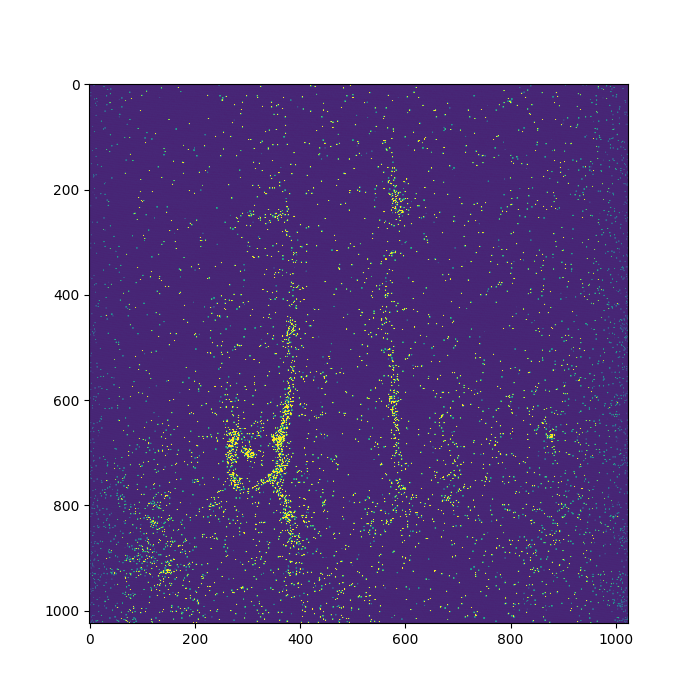

In [201]:
# Step 3 continued: Display the first frame and allow ROI selection
# re-run as many times as necessary to select multiple ROIS
plt.close()
print("Select the ROI by clicking and dragging on the image")
roi = select_roi(first_frame)
rois.append(roi.mask)

In [202]:
# Step 4: get average time traces for each ROI
time_trace = get_time_trace(tif_path, rois)

In [203]:
# Step 5: Get triggered averages
# get opto traces and 2p camera times
df = main.get_sync_df(trial_dir)

In [204]:
# get times for each camera frame - and with that get opto and times
cam_times = syncronization.edges(df['2p_frames'])[0]
cam_times = np.insert(cam_times, 0, 0) # first frame is at 0
opto_times = df['opto_stim'][cam_times].values
times = df['Time'][cam_times].values

In [205]:
#get trigger points
trigger_points = syncronization.edges(opto_times)[0]

In [215]:
win_neg = 50
win_pos = 100
ave = []
sem = []
for i in range(len(time_trace)):
    ave_i, sem_i = triggered_average(time_trace[i], trigger_points, win_neg, win_pos)
    ave.append(ave_i)
    sem.append(sem_i)

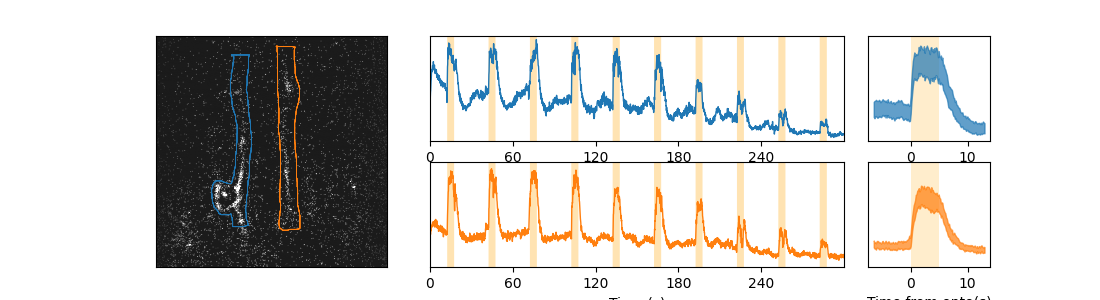

In [239]:
# Plot everything!!!
fig = plt.figure(figsize=(11, 3))
# subplot2grid((total divisions), (top left occupied), colums/rows it occupies))
ax_raw = ['','']
ax_trig= ['','']
ax_im = plt.subplot2grid((2, 6), (0, 0), rowspan=2, colspan=2)
ax_raw[0] = plt.subplot2grid((2, 6), (0, 2), colspan=3)
ax_raw[1] = plt.subplot2grid((2, 6), (1, 2), colspan=3)
ax_trig[0] = plt.subplot2grid((2, 6), (0, 5))
ax_trig[1] = plt.subplot2grid((2, 6), (1, 5))

# plot the average image plus the ROIs
roi_colors = ['tab:blue', 'tab:orange']
ax_im.imshow(first_frame, cmap='gray', vmax=1000)
ax_im.set_xticks([])
ax_im.set_yticks([])
for i,roi in enumerate(rois):
    ax_im.contour(roi, colors=roi_colors[i], linewidths=0.5)


for i,roi in enumerate(rois):
    # plot the raw time trace
    ax_raw[i].fill(times,opto_times * 200, color='orange', alpha=0.3, linewidth=0)
    ax_raw[i].plot(times,time_trace[i,0:len(times)], linewidth=1, color=roi_colors[i])
    ax_raw[i].set_xlim(np.min(times), np.max(times))
    ax_raw[i].set_xticks(np.arange(0, np.max(times), 60))
    ax_raw[i].set_ylim(np.min(time_trace[i])-0.5, np.max(time_trace[i])+0.5)
    ax_raw[i].set_yticks([])

    # plot the triggered average
    ax_trig[i].fill_between([0,5], [0,0], [100,100], color='orange', alpha=0.2, linewidth=0)
    ax_trig[i].fill_between(times[0:len(ave[i])]-times[0]-times[win_neg], ave[i]+sem[i], ave[i]-sem[i], color=roi_colors[i], alpha=0.7, linewidth=1)
    ax_trig[i].set_ylim(np.min(ave[i])-1, np.max(ave[i])+2)
    ax_trig[i].set_yticks([])

    if i == 1:
        ax_raw[i].set_xlabel('Time (s)')
        ax_trig[i].set_xlabel('Time from opto(s)')

plt.show()

# save figure
save_path = tif_path.replace('.tif', '_triggered_average.png')
plt.savefig(save_path, bbox_inches='tight')

In [237]:
save_path

'/mnt/upramdya_data/MA/240919_T-43-gcamp_Ablation/Fly1/002_pre-beh/2p/0001_Untitled/channel_1_triggered_average.png'